In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cnu-ml/sample_submission.csv
/kaggle/input/cnu-ml/train.csv
/kaggle/input/cnu-ml/test.csv


In [3]:
!pip install mglearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 2.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582639 sha256=6668fe6618b21b04bb55c4331a457fad6b209e1381a40f2957b3b4290497b4f3
  Stored in directory: /root/.cache/pip/wheels/f1/17/e1/1720d6dcd70187b6b6c3750cb3508798f2b1d57c9d3214b08b
Successfully built mglearn


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


import warnings
warnings.filterwarnings(action='ignore')

In [5]:
import matplotlib
import matplotlib.font_manager as fm

def change_matplotlib_font(font_download_url):
    FONT_PATH = 'MY_FONT'
    
    font_download_cmd = f"wget {font_download_url} -O {FONT_PATH}.zip"
    unzip_cmd = f"unzip -o {FONT_PATH}.zip -d {FONT_PATH}"
    os.system(font_download_cmd)
    os.system(unzip_cmd)
    
    font_files = fm.findSystemFonts(fontpaths=FONT_PATH)
    for font_file in font_files:
        fm.fontManager.addfont(font_file)

    font_name = fm.FontProperties(fname=font_files[0]).get_name()
    matplotlib.rc('font', family=font_name)
    print("font family: ", plt.rcParams['font.family'])
    
font_download_url = "https://fonts.google.com/download?family=Noto%20Sans%20KR"
change_matplotlib_font(font_download_url)

--2022-11-08 13:39:02--  https://fonts.google.com/download?family=Noto%20Sans%20KR
Resolving fonts.google.com (fonts.google.com)... 108.177.13.138, 108.177.13.101, 108.177.13.100, ...
Connecting to fonts.google.com (fonts.google.com)|108.177.13.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘MY_FONT.zip’

     0K .......... .......... .......... .......... .......... 1.02M
    50K .......... .......... .......... .......... .......... 2.53M
   100K .......... .......... .......... .......... .......... 3.04M
   150K .......... .......... .......... .......... .......... 2.81M
   200K .......... .......... .......... .......... .......... 2.91M
   250K .......... .......... .......... .......... .......... 4.73M
   300K .......... .......... .......... .......... .......... 4.88M
   350K .......... .......... .......... .......... .......... 8.80M
   400K .......... .......... .......... .......... .......... 7.92M


Archive:  MY_FONT.zip
  inflating: MY_FONT/OFL.txt         
  inflating: MY_FONT/NotoSansKR-Thin.otf  
  inflating: MY_FONT/NotoSansKR-Light.otf  
  inflating: MY_FONT/NotoSansKR-Regular.otf  
  inflating: MY_FONT/NotoSansKR-Medium.otf  
  inflating: MY_FONT/NotoSansKR-Bold.otf  
  inflating: MY_FONT/NotoSansKR-Black.otf  
font family:  ['Noto Sans KR']


In [6]:
train_data = pd.read_csv('../input/cnu-ml/train.csv')
test_data = pd.read_csv('../input/cnu-ml/test.csv')
#all_data = pd.concat([train_data,test_data])

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60832 entries, 0 to 60831
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        60832 non-null  int64  
 1   순번        60832 non-null  int64  
 2   계약구분      60832 non-null  object 
 3   재계약횟수     60832 non-null  int64  
 4   거주개월      60832 non-null  int64  
 5   아파트 이름    60832 non-null  object 
 6   아파트 ID    60832 non-null  int64  
 7   아파트 평점    60832 non-null  int64  
 8   호실고유번호    60832 non-null  int64  
 9   층         60832 non-null  int64  
 10  평형대       60832 non-null  int64  
 11  계약자고유번호   60832 non-null  int64  
 12  계약서고유번호   60832 non-null  int64  
 13  입주연도      60832 non-null  int64  
 14  퇴거연도      18033 non-null  float64
 15  거주연도      60832 non-null  int64  
 16  월세(원)     60832 non-null  int64  
 17  보증금(원)    60832 non-null  int64  
 18  대표나이      60832 non-null  int64  
 19  나이        60832 non-null  int64  
 20  성별        60832 non-null  ob

퇴거연도      18033 
관련없으면 삭제

In [8]:
print(train_data.isnull().sum())
print('------------------------')
print(test_data.isnull().sum())

id              0
순번              0
계약구분            0
재계약횟수           0
거주개월            0
아파트 이름          0
아파트 ID          0
아파트 평점          0
호실고유번호          0
층               0
평형대             0
계약자고유번호         0
계약서고유번호         0
입주연도            0
퇴거연도        42799
거주연도            0
월세(원)           0
보증금(원)          0
대표나이            0
나이              0
성별              0
결혼여부            0
거주자 수           0
move_out        0
dtype: int64
------------------------
id             0
순번             0
계약구분           0
재계약횟수          0
거주개월           0
아파트 이름         0
아파트 ID         0
아파트 평점         0
호실고유번호         0
층              0
평형대            0
계약자고유번호        0
계약서고유번호        0
입주연도           0
퇴거연도       18343
거주연도           0
월세(원)          0
보증금(원)         0
대표나이           0
나이             0
성별             0
결혼여부           0
거주자 수          0
dtype: int64


In [9]:
train_data['퇴거연도'].value_counts()

2019.0    2414
2020.0    2299
2018.0    2269
2017.0    2229
2016.0    1894
2015.0    1629
2014.0    1322
2013.0     981
2012.0     883
2011.0     807
2010.0     655
2009.0     452
2008.0     199
Name: 퇴거연도, dtype: int64

In [10]:
train_data['move_out'].value_counts()

1    57882
0     2950
Name: move_out, dtype: int64

In [11]:
train_data_drop = train_data[train_data['퇴거연도'].notnull()]
train_data_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18033 entries, 0 to 60831
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        18033 non-null  int64  
 1   순번        18033 non-null  int64  
 2   계약구분      18033 non-null  object 
 3   재계약횟수     18033 non-null  int64  
 4   거주개월      18033 non-null  int64  
 5   아파트 이름    18033 non-null  object 
 6   아파트 ID    18033 non-null  int64  
 7   아파트 평점    18033 non-null  int64  
 8   호실고유번호    18033 non-null  int64  
 9   층         18033 non-null  int64  
 10  평형대       18033 non-null  int64  
 11  계약자고유번호   18033 non-null  int64  
 12  계약서고유번호   18033 non-null  int64  
 13  입주연도      18033 non-null  int64  
 14  퇴거연도      18033 non-null  float64
 15  거주연도      18033 non-null  int64  
 16  월세(원)     18033 non-null  int64  
 17  보증금(원)    18033 non-null  int64  
 18  대표나이      18033 non-null  int64  
 19  나이        18033 non-null  int64  
 20  성별        18033 non-null  ob

In [12]:
train_data = train_data.drop(['퇴거연도'],1).copy()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60832 entries, 0 to 60831
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        60832 non-null  int64 
 1   순번        60832 non-null  int64 
 2   계약구분      60832 non-null  object
 3   재계약횟수     60832 non-null  int64 
 4   거주개월      60832 non-null  int64 
 5   아파트 이름    60832 non-null  object
 6   아파트 ID    60832 non-null  int64 
 7   아파트 평점    60832 non-null  int64 
 8   호실고유번호    60832 non-null  int64 
 9   층         60832 non-null  int64 
 10  평형대       60832 non-null  int64 
 11  계약자고유번호   60832 non-null  int64 
 12  계약서고유번호   60832 non-null  int64 
 13  입주연도      60832 non-null  int64 
 14  거주연도      60832 non-null  int64 
 15  월세(원)     60832 non-null  int64 
 16  보증금(원)    60832 non-null  int64 
 17  대표나이      60832 non-null  int64 
 18  나이        60832 non-null  int64 
 19  성별        60832 non-null  object
 20  결혼여부      60832 non-null  object
 21  거주자 수     60

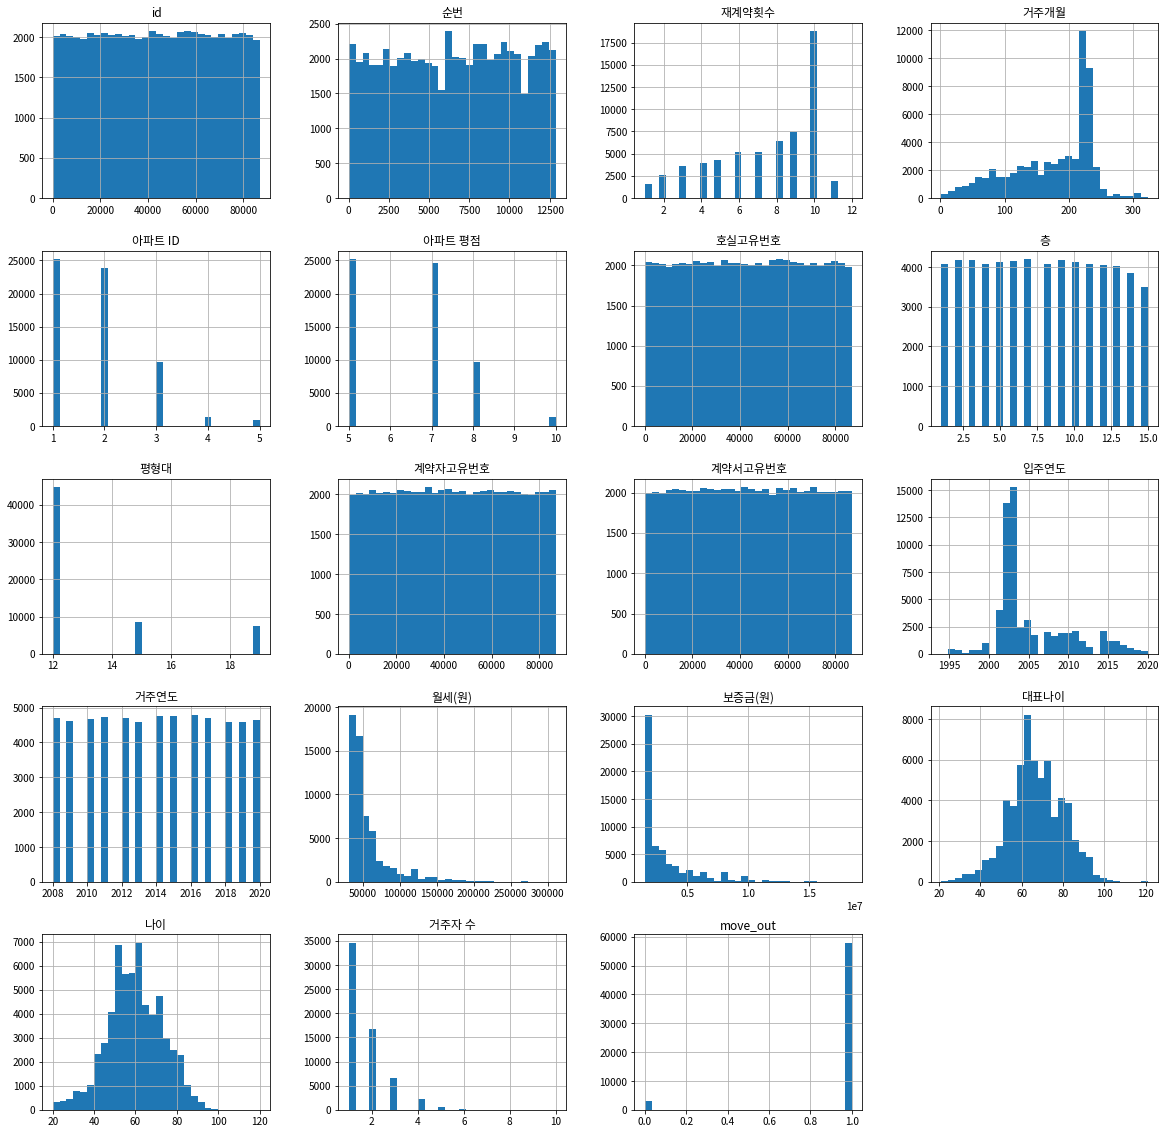

In [13]:
g = train_data.hist(bins= 30 ,figsize=(20,20))

In [13]:
num  = train_data.columns[train_data.dtypes == 'int64']
cat = train_data.columns[train_data.dtypes != 'int64']

In [14]:
for col in cat:
     print(f'{col} \n{train_data[col].value_counts()}')

계약구분 
유효    42799
해지    18033
Name: 계약구분, dtype: int64
아파트 이름 
비둘기아파트      25228
용지아파트       23792
지산5단지아파트     9591
까치아파트        1329
강남아파트         892
Name: 아파트 이름, dtype: int64
성별 
여    35812
남    25020
Name: 성별, dtype: int64
결혼여부 
미혼    52013
기혼     8819
Name: 결혼여부, dtype: int64


In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

for c in cat:
    le = LabelEncoder()
    print(c)
    if train_data[c].dtypes == 'object':
        le = le.fit(train_data[c])
        train_data[c] = le.transform(train_data[c])

test_data = test_data.drop(['퇴거연도'],1).copy()
for c in cat:
    le = LabelEncoder()
    print(c)
    if test_data[c].dtypes == 'object':
        le = le.fit(test_data[c])
        test_data[c] = le.transform(test_data[c])
        

계약구분
아파트 이름
성별
결혼여부
계약구분
아파트 이름
성별
결혼여부


<AxesSubplot:>

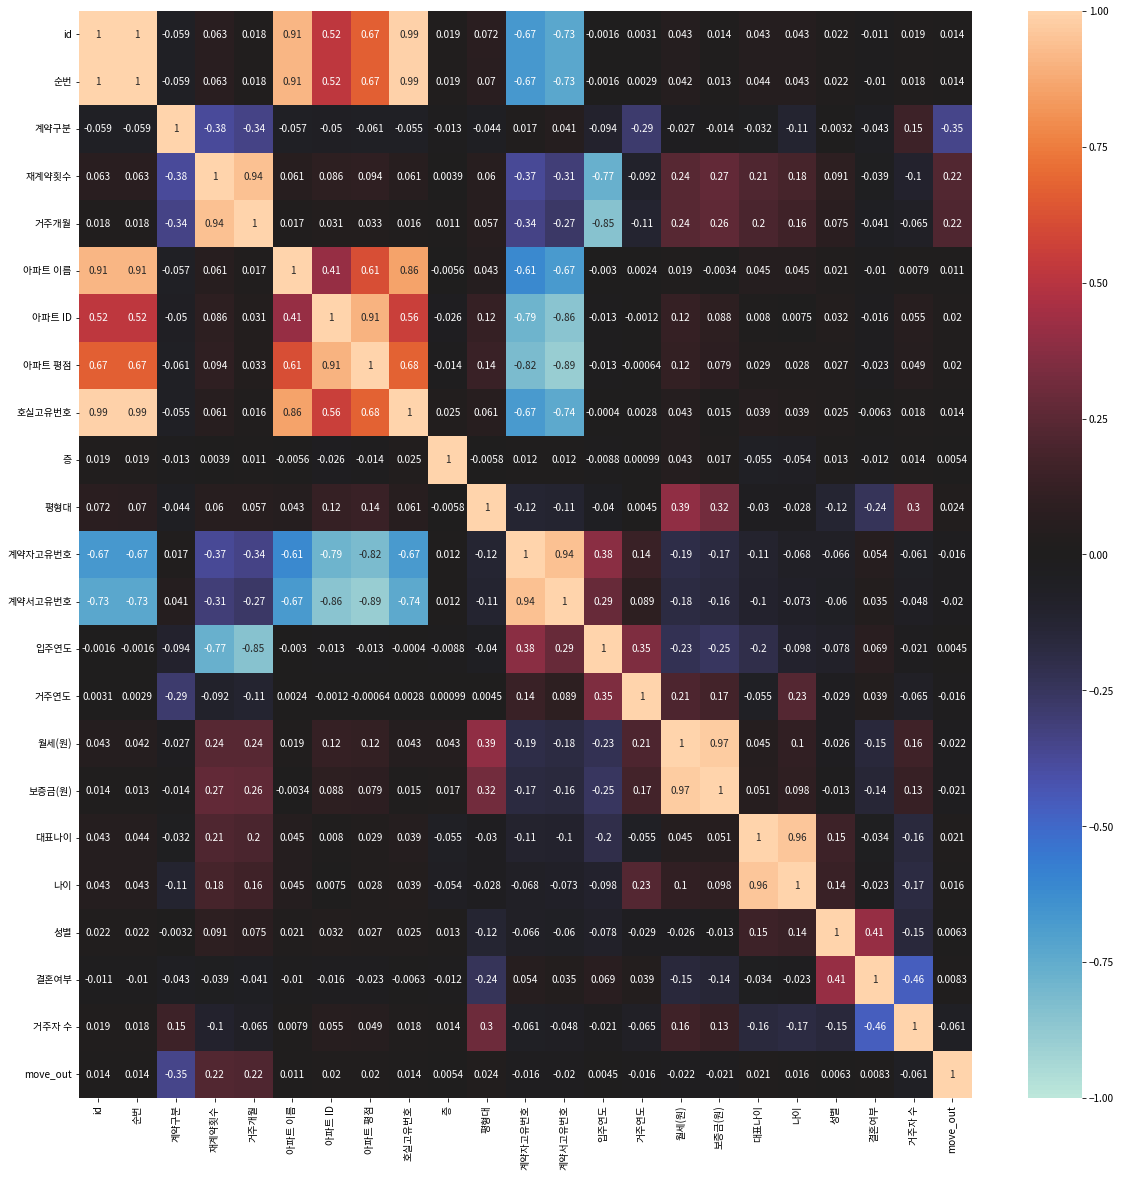

In [16]:
cor = train_data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(data=cor, vmin=-1 , vmax=1,center=0,annot=True)

In [17]:
n_col = ['계약자고유번호','계약서고유번호']

거주 개월과 거주 연도는 매우 상관성이 높아 보임


In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train_data, train_data["평형대"]):
    strat_train_set = train_data.loc[train_index]
    strat_test_set = train_data.loc[test_index]

In [19]:
train_data = strat_train_set.drop("move_out", axis=1) # 훈련 세트를 위해 레이블 삭제
train_labels = strat_train_set["move_out"].copy()

In [20]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(train_data, train_labels)

RandomForestRegressor(random_state=42)

In [21]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준 편차:", scores.std())

In [22]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, train_data, train_labels,
                                scoring="roc_auc", cv=10)
display_scores(forest_scores)

KeyboardInterrupt: 

In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [1,5,10,20,30,50,100], 'max_features': [1,2,5,10,20,30,50]},
    {'bootstrap': [False], 'n_estimators': [1,3,5,10,30,50,100], 'max_features': [1, 20, 30, 40]},
  ]


forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='roc_auc',
                           return_train_score=True)
grid_search.fit(train_data, train_labels)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [1, 2, 5, 10, 20, 30, 50],
                          'n_estimators': [1, 5, 10, 20, 30, 50, 100]},
                         {'bootstrap': [False], 'max_features': [1, 20, 30, 40],
                          'n_estimators': [1, 3, 5, 10, 30, 50, 100]}],
             return_train_score=True, scoring='roc_auc')

In [24]:
grid_search.best_params_

{'max_features': 20, 'n_estimators': 100}

In [25]:
grid_search.best_estimator_

RandomForestRegressor(max_features=20, random_state=42)

In [26]:
forest_reg = RandomForestRegressor(max_features=20, n_estimators=100,random_state=6)
forest_reg.fit(train_data, train_labels)

RandomForestRegressor(max_features=20, random_state=6)

In [27]:
test_predicted = forest_reg.predict(test_data)
sample_sub = pd.DataFrame({'id': test_data['id'], 'move_out': test_predicted})

In [47]:
sample_sub['move_out'] = sample_sub['move_out'].apply(lambda x : 1 if x> 0.5 else 0)

In [28]:
sample_sub

,id,move_out
0,77315,1.0
1,9515,1.0
2,1668,1.0
3,57273,1.0
4,19049,1.0
...,...,...
26067,81241,1.0
26068,83076,1.0
26069,25820,1.0
26070,36133,1.0


In [29]:
sample_sub.to_csv("submission3.csv", index=False)